# SHAP analysis of RANDM thermospheric density model
This notebook is one companion piece to Bard, Murphy, Halford (2025): "Elucidating the Grey Atmosphere: SHAP Value Analysis of a Random Forest Atmospheric Neutral Density Model".

## Part D: Individual Event SHAP Analysis and Extension to Full-Earth

This notebook uses the saved SHAP explanations from Part A to generate the plots shown in the paper; here, Figures 8-14.

#### Requirements
- numpy
- pandas
- matplotlib
- fasttreeshap
- shap
- cartopy
- mltdm

Also requires local script `shap_analysis`.

#### References
- SHAP paper (arxiv link)
- saved SHAP explanations (zenodo link)
- Murphy+2025 (RANDM model paper): https://doi.org/10.1029/2024SW003928
- MLTDM repository: https://github.com/kylermurphy/mltdm/

In [1]:
import numpy as np
import numpy.random as rand
import pandas as pd
import time as pytime
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
from shap_analysis import PolarBear

In [2]:
import fasttreeshap as fts
from fasttreeshap.plots import beeswarm, waterfall, bar
import shap

In [3]:
import mltdm
from mltdm.den_fx import fx_den

In [4]:
# hack to save and load minimal viable explanation, 
# since it takes a while to make
def save_explanation(fname, expln):
    # hack to avoid pickling and associated errors
    dta = expln.data.astype(float)
    np.savez(fname, values=expln.values, 
             base_values=expln.base_values, data=dta,
             feature_names=expln.feature_names, 
             output_names=expln.output_names, compute_time=expln.compute_time)

def load_explanation(fname):
    dat_dict = np.load(fname)
    return fts.Explanation(values = dat_dict["values"], base_values=dat_dict["base_values"], 
                           data=dat_dict["data"], feature_names=dat_dict["feature_names"], 
                           output_names=dat_dict["output_names"], 
                           compute_time=dat_dict["compute_time"])

# hack to blend multiple explanations together
def stack_expln(expln1, expln2):
    return fts.Explanation(values = np.vstack([expln1.values, expln2.values]), 
                             base_values = np.vstack([expln1.base_values, expln2.base_values]), 
                             data = np.vstack([expln1.data, expln2.data]),
                             feature_names=expln1.feature_names,
                            )

In [5]:
# functions to load feature data from hardcoded file
# Download file "FI_GEO_RF_data.h5" from Zenodo : <>

# data columns used in best-performing Murphy RF model
fgeo_col = ['1300_02', '43000_09', '85550_13', '94400_18', 'SYM_H index', 
            'AE', 'SatLat', 'cos_SatMagLT', 'sin_SatMagLT']

_fgeo_col_dict = {name: index for index, name in enumerate(fgeo_col)}

def _load_datafile(option: str = "test_d", path='./'):
    """
    Loads forest training/test data from CB's checkpointing of
    the train/test split in KM's Notebook (https://github.com/kylermurphy/mltdm/blob/main/Notebooks/RF_model.ipynb)

    option : str
        1. "test_d" : Grace B test data
        2. "train_d" : Grace B training data
        3. "oos_d" : Grace A
        4. "oos2_d" : CHAMP

    """

    return pd.read_hdf(path+"FI_GEO_RF_data.h5", option)


def load_data(storm: bool = None, option: str = "test_d", all_cols: bool = False, path='./'):
    """
    Loads pandas data array from file in `load_datafile`

    `storm` : bool | None
        1. None : load full data
        2. True : load storm data ("storm" == 1)
        3. False : load nonstorm data ("storm" == -1)

    option : str
        1. "test_d" : Grace B test data
        2. "train_d" : Grace B training data
        3. "oos_d" : Grace A
        4. "oos2_d" : CHAMP

    all_cols : bool
        If True, load all data columns
        If False, load just fgeo_columns used in best RF model

    path : str
        path to find FI_GEO_RF_data.h5 datafile, by default './'
    """

    dat = _load_datafile(option, path=path)

    if storm is not None:
        dat = dat[dat['storm'] == ((storm == True) - (storm == False))]

    return dat if all_cols else dat[fgeo_col]

In [6]:
# random sampler
NUM_SAMP = 2000
def sample(gen, df, num_samp=2000):
    """
    Samples df with num_samp points.

    gen: np.random.rand instance
        Used to generate random indices for sample selection
    df: pandas.dataframe
        data to sample
    num_samp : int
        number of points in sample
    """
    num_samp = min(num_samp, df.shape[0])
    ids = gen.choice(range(df.shape[0]), size = num_samp, replace=False)
    return df.iloc[ids]

#### load data

In [7]:
full_data = load_data(all_cols=True, option="test_d") # loads Grace B test data

In [8]:
# sort into more specific datasets
storm_data = full_data[full_data['storm'] == 1]
quiet_data = full_data[full_data['storm'] == -1]

In [9]:
mltdm_wrapper = fx_den(dropAE=False)
rf = mltdm_wrapper.rfmod # this is RANDM

Loading fx_den_bz2.skops, this will take a few minutes.


In [10]:
rf

RandomForestRegressor(max_features=0.5, min_samples_leaf=5, n_estimators=500,
                      n_jobs=10, oob_score=True, random_state=17)

In [11]:
NJOBS = 8 # number of cores/threads on your CPU
explainer = fts.TreeExplainer(rf, n_jobs = NJOBS)

## Single Events
The events we are looking at are semi-randomly chosen: 2 during a storm, one during a non-storm. One has a "high" density prediction, one "medium", and one "low".

In [12]:
high_evt = storm_data.iloc[4803]
med_evt = storm_data.iloc[4804]
low_evt = quiet_data.iloc[604]

In [13]:
high_evt

1300_02                         7.778282
43000_09                       10.102009
85550_13                         9.56579
94400_18                        9.332493
SYM_H index                        -25.0
AE                                 112.0
SatLat                          43.13684
cos_SatMagLT                   -0.815219
sin_SatMagLT                    0.579153
400kmDensity                    4.485137
DateTime             2003-03-07 05:15:00
storm                                  1
storm phase                            2
400kmDensity_pred               4.847418
Name: 62847, dtype: object

In [14]:
print("MLT high: ", 24.*np.arctan2(high_evt["sin_SatMagLT"], high_evt["cos_SatMagLT"])/(2*np.pi))

MLT high:  9.6406


In [15]:
med_evt

1300_02                         7.391199
43000_09                        9.927624
85550_13                        9.469308
94400_18                        9.234825
SYM_H index                        -44.0
AE                                 169.0
SatLat                         -14.01763
cos_SatMagLT                   -0.051369
sin_SatMagLT                     0.99868
400kmDensity                    1.664955
DateTime             2005-01-23 07:45:00
storm                                  1
storm phase                            2
400kmDensity_pred               1.621514
Name: 261021, dtype: object

In [16]:
print("MLT med: ",24.*np.arctan2(med_evt["sin_SatMagLT"], med_evt["cos_SatMagLT"])/(2*np.pi))

MLT med:  6.1963


In [17]:
low_evt

1300_02                         7.160848
43000_09                        9.815979
85550_13                        9.411937
94400_18                        9.186509
SYM_H index                         -1.0
AE                                 220.0
SatLat                          38.91635
cos_SatMagLT                   -0.694483
sin_SatMagLT                     0.71951
400kmDensity                    0.944242
DateTime             2010-03-29 16:05:00
storm                                 -1
storm phase                           -1
400kmDensity_pred               0.888769
Name: 805729, dtype: object

In [18]:
print("MLT low: ", 24.*np.arctan2(low_evt["sin_SatMagLT"], low_evt["cos_SatMagLT"])/(2*np.pi))

MLT low:  8.9324


#### Figure 8: bar plots for each event

In [19]:
high_shaps = explainer(high_evt[fgeo_col].to_frame().transpose())

In [20]:
# example waterfall plot
# copy shenangians needed since single event data somehow becomes a 2D array
from copy import deepcopy
high_shaps2 = deepcopy(high_shaps)
high_shaps2.base_values = high_shaps2.base_values[0][0]
high_shaps2.values = high_shaps2.values.squeeze()
high_shaps2.data = high_shaps2.data.squeeze()

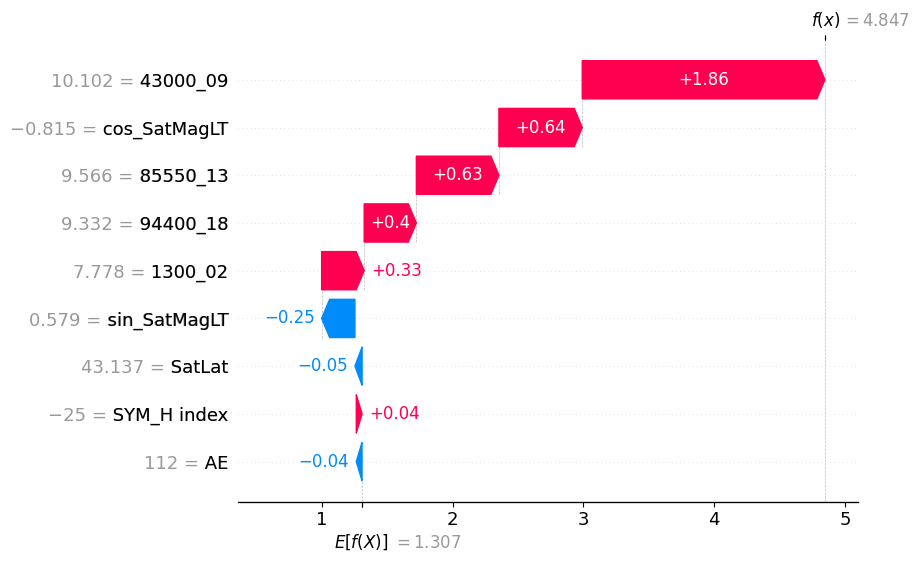

In [21]:
fts.plots.waterfall(high_shaps2)

In [37]:
f = plt.gcf()
fax = plt.gca()
fax.tick_params(size=20)
f.savefig("waterfallHighDen_paper.png", bbox_inches="tight")
f.clf()

In [22]:
med_shaps = explainer(med_evt[fgeo_col].to_frame().transpose())

In [23]:
med_shaps2 = deepcopy(med_shaps)
med_shaps2.base_values = med_shaps2.base_values[0][0]
med_shaps2.values = med_shaps2.values.squeeze()
med_shaps2.data = med_shaps2.data.squeeze()

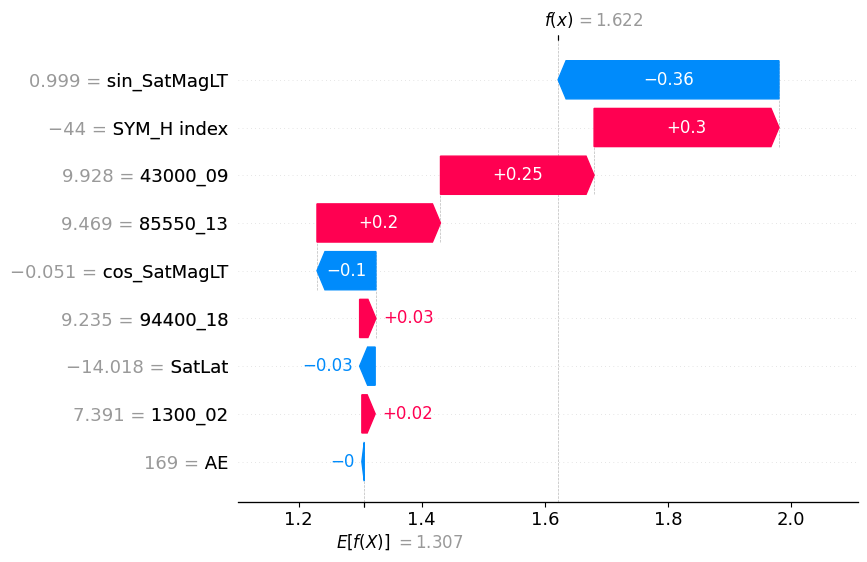

In [24]:
fts.plots.waterfall(med_shaps2)

In [103]:
f = plt.gcf()
f.savefig("waterfallMedDen.png", bbox_inches="tight")
f.clf()

In [25]:
low_shaps = explainer(low_evt[fgeo_col].to_frame().transpose())

In [26]:
low_shaps2 = deepcopy(low_shaps)
low_shaps2.base_values = low_shaps2.base_values[0][0]
low_shaps2.values = low_shaps2.values.squeeze()
low_shaps2.data = low_shaps2.data.squeeze()

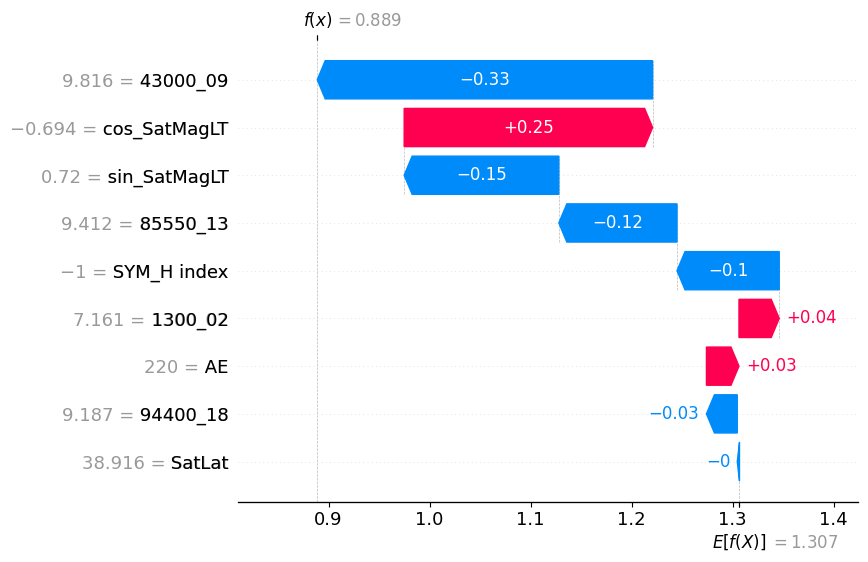

In [27]:
fts.plots.waterfall(low_shaps2)

In [78]:
f = plt.gcf()
f.savefig("waterfallLowDen.png", bbox_inches="tight")
f.clf()

#### Expand event data from single point to 2D Hemisphere Grid

In [19]:
n_lat = 12
n_mlt = 24
pb = PolarBear(n_lat, n_mlt)

In [20]:
high_north_qq = high_evt["SatLat"] >= 0.
high_grid, high_sat_lat_msh = pb.make_grid(high_evt, north=high_north_qq)

In [21]:
# Uncomment to make shap vals for high grid
"""
print("start event mapping")
tfirst = pytime.perf_counter()
high_shap_vals = explainer(high_grid)
tnow = pytime.perf_counter()
print(f"Time taken: {tnow - tfirst}")
save_explanation("high_evt_shap", high_shap_vals)
"""

'\nprint("start event mapping")\ntfirst = pytime.perf_counter()\nhigh_shap_vals = explainer(high_grid)\ntnow = pytime.perf_counter()\nprint(f"Time taken: {tnow - tfirst}")\nsave_explanation("high_evt_shap", high_shap_vals)\n'

In [22]:
# pre-calculated shap values stored in directory:
local_dir = './SHAP_values/'

In [23]:
# if already done shap calculation
high_shap_vals = load_explanation(local_dir+"high_evt_shap.npz")

In [24]:
# now expand to a 2D grid (med)
med_north_qq = med_evt["SatLat"] >= 0.
med_grid, med_sat_lat_msh = pb.make_grid(med_evt, north=med_north_qq)

In [25]:
#Uncomment to get SHAP values on grid for medium event
"""
print("start event mapping")
tfirst = pytime.perf_counter()
med_shap_vals = explainer(med_grid)
tnow = pytime.perf_counter()
print(f"Time taken: {tnow - tfirst}")
save_explanation("med_evt_shap", med_shap_vals)
"""

'\nprint("start event mapping")\ntfirst = pytime.perf_counter()\nmed_shap_vals = explainer(med_grid)\ntnow = pytime.perf_counter()\nprint(f"Time taken: {tnow - tfirst}")\nsave_explanation("med_evt_shap", med_shap_vals)\n'

In [26]:
med_shap_vals = load_explanation(local_dir+"med_evt_shap.npz")

In [27]:
# now expand to a 2D grid (low)
low_north_qq = low_evt["SatLat"] >= 0.
low_grid, low_sat_lat_msh = pb.make_grid(low_evt, north=low_north_qq)

In [28]:
# Uncomment to generate shap_values on Grid for low event
"""
print("start event mapping")
tfirst = pytime.perf_counter()
low_shap_vals = explainer(low_grid)
tnow = pytime.perf_counter()
print(f"Time taken: {tnow - tfirst}")
save_explanation("low_evt_shap", low_shap_vals)
"""

'\nprint("start event mapping")\ntfirst = pytime.perf_counter()\nlow_shap_vals = explainer(low_grid)\ntnow = pytime.perf_counter()\nprint(f"Time taken: {tnow - tfirst}")\nsave_explanation("low_evt_shap", low_shap_vals)\n'

In [29]:
low_shap_vals = load_explanation(local_dir+"low_evt_shap.npz")

#### Figures 9-11 : Global predictions for single events

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


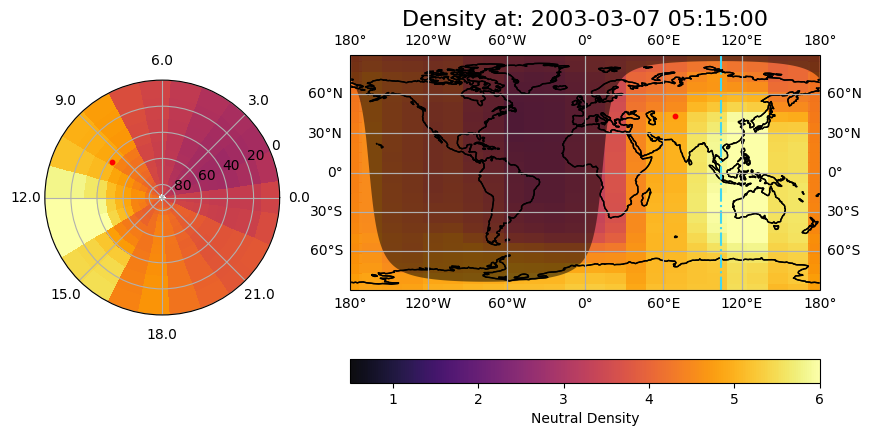

In [36]:
date = high_evt["DateTime"]
vmin = 0.5
vmax = 6

fig = plt.figure(figsize=(10,6))

gs = GridSpec(1, 2, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0], projection='polar')
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

high_geo = pb.make_geo_grid(high_evt)

pb.plot_density(ax1, rf, high_evt, high_grid, high_sat_lat_msh, high_north_qq, [vmin, vmax])
im = pb.plot_geo_den(ax2, rf, high_evt, high_geo, vr=[vmin,vmax])
pb.plot_geo_night(ax2, high_evt)

#fig.delaxes(fig.axes[2])
#fig.delaxes(fig.axes[2])

fig.colorbar(im, ax=ax2, orientation='horizontal', label='Neutral Density')
fig.savefig("highGEO_density.png", bbox_inches='tight')

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


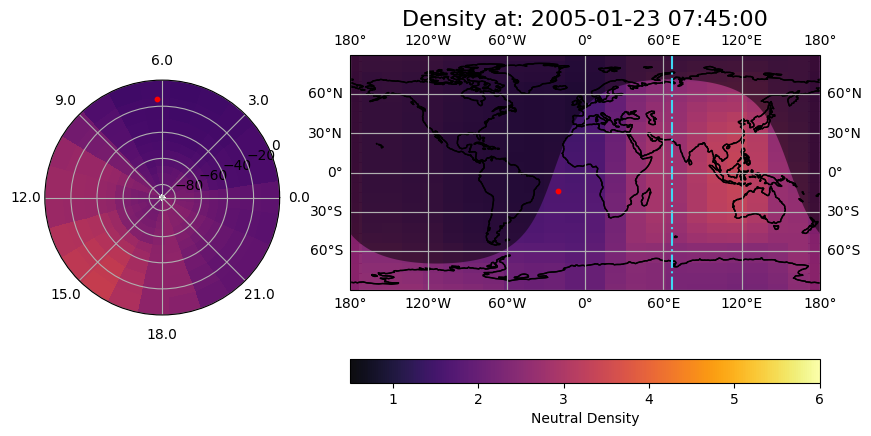

In [34]:
date = med_evt["DateTime"]
vmin = 0.5
vmax = 6

fig = plt.figure(figsize=(10,6))

gs = GridSpec(1, 2, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0], projection='polar')
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

med_geo = pb.make_geo_grid(med_evt)

pb.plot_density(ax1, rf, med_evt, med_grid, med_sat_lat_msh, med_north_qq, [vmin, vmax])
im = pb.plot_geo_den(ax2, rf, med_evt, med_geo, vr=[vmin,vmax])
pb.plot_geo_night(ax2, med_evt)

#fig.delaxes(fig.axes[2])
#fig.delaxes(fig.axes[2])

fig.colorbar(im, ax=ax2, orientation='horizontal', label='Neutral Density')
fig.savefig("medGEO_density.png", bbox_inches='tight')

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


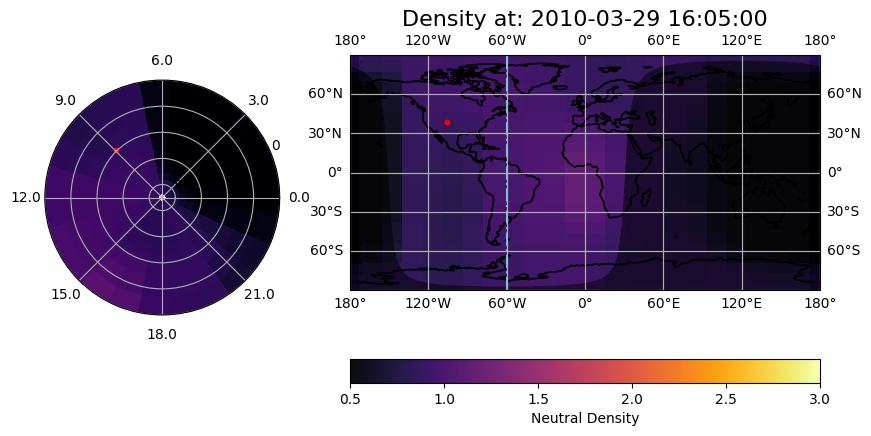

In [35]:
date = low_evt["DateTime"]
vmin = 0.5
vmax = 3

fig = plt.figure(figsize=(10,6))

gs = GridSpec(1, 2, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0], projection='polar')
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

low_geo = pb.make_geo_grid(low_evt)

pb.plot_density(ax1, rf, low_evt, low_grid, low_sat_lat_msh, low_north_qq, [vmin, vmax])
im = pb.plot_geo_den(ax2, rf, low_evt, low_geo, vr=[vmin,vmax])
pb.plot_geo_night(ax2, low_evt)

#fig.delaxes(fig.axes[2])
#fig.delaxes(fig.axes[2])

fig.colorbar(im, ax=ax2, orientation='horizontal', label='Neutral Density')
fig.savefig("lowGEO_density.png", bbox_inches='tight')

#### Figures 12-14: individual SHAP values for events

In [28]:
# HIGH HEX

fig = plt.Figure(figsize=(12,8))
gs = fig.add_gridspec(2,3)
ax0 = fig.add_subplot(gs[0,0], projection="polar")
ax1 = fig.add_subplot(gs[0,1], projection="polar")
ax2 = fig.add_subplot(gs[0,2], projection="polar")
ax3 = fig.add_subplot(gs[1,0], projection="polar")
ax4 = fig.add_subplot(gs[1,1], projection="polar")
ax5 = fig.add_subplot(gs[1,2], projection="polar")

for nme,axis in zip(["43000_09", "85550_13","1300_02","cos_SatMagLT", "sin_SatMagLT","SYM_H index"], [ax0, ax1, ax2, ax3, ax4, ax5]):
    i = _fgeo_col_dict[nme]
    shp = high_shap_vals.values[:,i]
    min_shap = shp.min()
    max_shap = shp.max()
    #min_shap = min(0, shp.min())
    #max_shap = max(0, shp.max())
    img = pb.plot_shap(axis, high_evt, shp, nme, high_sat_lat_msh, high_north_qq, [min_shap, max_shap])
    fig.colorbar(img, ax=axis, fraction=0.046, pad=0.06)
    axis.set_title(f"Factor: {nme}", pad=25, size=16)
    #ax.text(0.06, 0.06, f"{date}", transform=figP.transFigure, size=13)
    fig.tight_layout()
    #fig.savefig("Hex_High_Shap.png")

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


In [39]:
# MED HEX

fig = plt.Figure(figsize=(12,8))
gs = fig.add_gridspec(2,3)
ax0 = fig.add_subplot(gs[0,0], projection="polar")
ax1 = fig.add_subplot(gs[0,1], projection="polar")
ax2 = fig.add_subplot(gs[0,2], projection="polar")
ax3 = fig.add_subplot(gs[1,0], projection="polar")
ax4 = fig.add_subplot(gs[1,1], projection="polar")
ax5 = fig.add_subplot(gs[1,2], projection="polar")

for nme,axis in zip(["43000_09", "85550_13","1300_02","cos_SatMagLT", "sin_SatMagLT","SYM_H index"], [ax0, ax1, ax2, ax3, ax4, ax5]):
    i = _fgeo_col_dict[nme]
    shp = med_shap_vals.values[:,i]
    min_shap = shp.min()
    max_shap = shp.max()
    #min_shap = min(0, shp.min())
    #max_shap = max(0, shp.max())
    img = pb.plot_shap(axis, med_evt, shp, nme, med_sat_lat_msh, med_north_qq, [min_shap, max_shap])
    fig.colorbar(img, ax=axis, fraction=0.046, pad=0.06)
    axis.set_title(f"Factor: {nme}", pad=25, size=16)
    #ax.text(0.06, 0.06, f"{date}", transform=figP.transFigure, size=13)
    fig.tight_layout()
    #fig.savefig("Hex_Med_Shap.png")

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


In [36]:
# LOW HEX

fig = plt.Figure(figsize=(12,8))
gs = fig.add_gridspec(2,3)
ax0 = fig.add_subplot(gs[0,0], projection="polar")
ax1 = fig.add_subplot(gs[0,1], projection="polar")
ax2 = fig.add_subplot(gs[0,2], projection="polar")
ax3 = fig.add_subplot(gs[1,0], projection="polar")
ax4 = fig.add_subplot(gs[1,1], projection="polar")
ax5 = fig.add_subplot(gs[1,2], projection="polar")

for nme,axis in zip(["43000_09", "85550_13","1300_02","cos_SatMagLT", "sin_SatMagLT","SYM_H index"], [ax0, ax1, ax2, ax3, ax4, ax5]):
    i = _fgeo_col_dict[nme]
    shp = low_shap_vals.values[:,i]
    min_shap = shp.min()
    max_shap = shp.max()
    #min_shap = min(0, shp.min())
    #max_shap = max(0, shp.max())
    img = pb.plot_shap(axis, low_evt, shp, nme, low_sat_lat_msh, low_north_qq, [min_shap, max_shap])
    fig.colorbar(img, ax=axis, fraction=0.046, pad=0.06)
    axis.set_title(f"Factor: {nme}", pad=25, size=16)
    #ax.text(0.06, 0.06, f"{date}", transform=figP.transFigure, size=13)
    fig.tight_layout()
    #fig.savefig("Hex_Low_Shap.png")

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


##### end